In [110]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"C:\Users\HP\machin learning\face_mask_detection\Real-Time Face Mask Detection OpenCV Python\Dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(96, 96))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)


[INFO] loading images...


In [111]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data , dtype='float32')
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)


In [112]:
len(testY)

1198

In [113]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


In [120]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(96 , 96 , 3)))
print(baseModel.output)
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3, 1280), dtype=tf.float32, name=None), name='out_relu/Relu6:0', description="created by layer 'out_relu'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_28[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                  

 rmalization)                                                                                     
                                                                                                  
 block_3_expand_relu (ReLU)  (None, 24, 24, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 25, 25, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 12, 12, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_d

 seConv2D)                                                                                        
                                                                                                  
 block_6_depthwise_BN (Batc  (None, 6, 6, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 6, 6, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 6, 6, 64)             12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
          

 block_9_project_BN (BatchN  (None, 6, 6, 64)             256       ['block_9_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_9_add (Add)           (None, 6, 6, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 6, 6, 384)            24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 6, 6, 384)            1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
          

 block_13_expand_BN (BatchN  (None, 6, 6, 576)            2304      ['block_13_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_13_expand_relu (ReLU  (None, 6, 6, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 7, 7, 576)            0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 3, 3, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D

                                                                                                  
 block_16_depthwise (Depthw  (None, 3, 3, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 3, 3, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 3, 3, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_

In [122]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, weight_decay=INIT_LR / EPOCHS)
model.summary()
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])


[INFO] compiling model...
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_28[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0       

 block_3_expand_relu (ReLU)  (None, 24, 24, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 25, 25, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 12, 12, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 12, 12, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 6, 6, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 6, 6, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 6, 6, 64)             12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 6, 6, 64)             256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 6, 6, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 6, 6, 384)            24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 6, 6, 384)            1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 6, 6, 384)            0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 6, 6, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 7, 7, 576)            0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 3, 3, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 3, 3, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 3, 3, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 3, 3, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [123]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS ),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs= EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")

predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


[INFO] training head...
Epoch 1/20
149/149 [==============================] - 67s 350ms/step - loss: 0.3968 - accuracy: 0.8668 - val_loss: 0.0582 - val_accuracy: 0.9858
Epoch 2/20
149/149 [==============================] - 50s 333ms/step - loss: 0.1092 - accuracy: 0.9699 - val_loss: 0.0434 - val_accuracy: 0.9866
Epoch 3/20
149/149 [==============================] - 50s 332ms/step - loss: 0.0730 - accuracy: 0.9777 - val_loss: 0.0347 - val_accuracy: 0.9875
Epoch 4/20
149/149 [==============================] - 50s 333ms/step - loss: 0.0609 - accuracy: 0.9817 - val_loss: 0.0317 - val_accuracy: 0.9875
Epoch 5/20
149/149 [==============================] - 51s 342ms/step - loss: 0.0557 - accuracy: 0.9840 - val_loss: 0.0306 - val_accuracy: 0.9875
Epoch 6/20
149/149 [==============================] - 51s 339ms/step - loss: 0.0564 - accuracy: 0.9828 - val_loss: 0.0293 - val_accuracy: 0.9875
Epoch 7/20
149/149 [==============================] - 50s 334ms/step - loss: 0.0464 - accuracy: 0.9844 - v

In [124]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("withmask_&_without_mask_detector.model", save_format="h5")


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       599
without_mask       0.99      0.99      0.99       599

    accuracy                           0.99      1198
   macro avg       0.99      0.99      0.99      1198
weighted avg       0.99      0.99      0.99      1198

[INFO] saving mask detector model...


C:\Users\HP\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


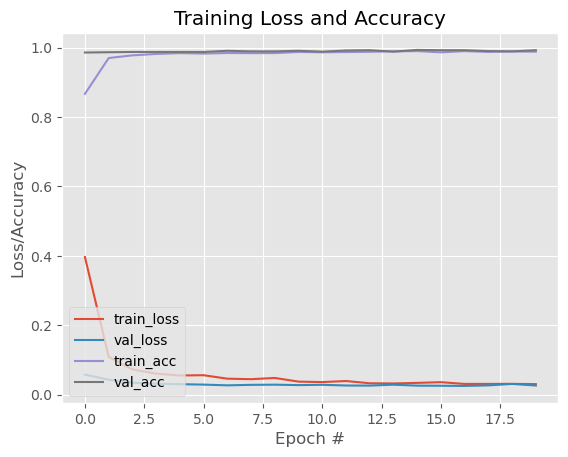

In [125]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")